# Variational Autoencoder for Quantum Transport Experiment 

This notebook implement a variational autoencoder that can recognize features of Quantum Point Contact (QPC) and non-QPC features. It can then be used to represent devices' transport ballisticity with a small number of latent parameters. The latent parameters are plotted with t-SNE technique.  

In [51]:
from keras.datasets import mnist
import numpy as np
from keras.layers import Dense, Input, InputLayer, Conv1D, MaxPool1D, UpSampling1D, Lambda , Flatten, Reshape
from keras import backend as K
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import TensorBoard, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

#### Load and Preprocess data

1.0


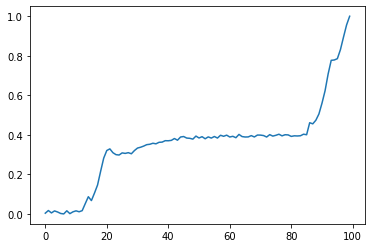

In [63]:
import numpy as np
directory = 'C:/Users/NBI/Documents/ML_QPC_QD/Training_data/2020-05-05/data_'
for i in range(7):
    filename = directory+str(i)+'.csv'
    if i==0:
        data = np.loadtxt(filename, delimiter=',')
    else:
        data1 = np.loadtxt(filename, delimiter=',')
        data=np.concatenate((data,data1),axis=0)

img_rows, img_cols = 1, 100
def prep_data(raw):
    raw = raw[~np.isnan(raw).any(axis=1)]
    x = raw[:,0:100]
    y = raw[:, 100]
    #out_y = keras.utils.to_categorical(y, num_classes)
    num_images = raw.shape[0]
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x.T).T
    out_x = x.reshape(num_images, img_cols, 1)
    out_y = y
    return out_x, out_y

x, y = prep_data(data)
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.15,shuffle=True)

X_train = X_train.reshape(len(X_train),np.prod(X_train.shape[1:]),1)
X_test = X_test.reshape(len(X_test),np.prod(X_test.shape[1:]),1)
n=1
plt.plot(X_train[n,:])
print(y_train[n])

#### Build the encoder
The encoder is based Convolutional and fully-connected neural network

In [82]:
K.clear_session()
original_dim = 100
##Dimension of latent vactors
encoding_dim=8
intermediate_dim = 64
inputs = Input(shape=(original_dim,1),name = 'inputs')
encoded = Conv1D(64,kernel_size=3, strides=1, activation='relu',padding='same')(inputs)
encoded = MaxPool1D(2)(encoded)
encoded = Conv1D(64,kernel_size=3, strides=1,activation = 'relu',padding='same')(encoded)
encoded = MaxPool1D(2)(encoded)
encoded = Conv1D(32,kernel_size=3, strides=1,activation = 'relu',padding='same')(encoded)
encoded = Flatten()(encoded)
encoded = Dense (encoding_dim*2,activation = 'relu')(encoded)

In [83]:
def sampling(args):
    z_mean = args[:,0:encoding_dim]
    z_log_var = args[:,encoding_dim:2*encoding_dim]
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch,dim))
    return z_mean + K.exp(0.5 * z_log_var)*epsilon 
sampling(encoded)
z_mean = encoded[:,0:encoding_dim]
z_log_var = encoded[:,encoding_dim:2*encoding_dim]

In [84]:
z = Lambda(sampling, output_shape=(encoding_dim,))(encoded)
encoder = Model(inputs,z)
encoder.summary()
#plot_model(encoder,show_shapes=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 100, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 32)            6176      
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0   

#### Build the decoder and autoencoder

In [85]:
latent_inputs = Input(shape=(encoding_dim,),name = 'latent_inputs')
decoded = Dense(800,activation='relu')(latent_inputs)
decoded = Reshape(target_shape=(25,32))(decoded)
decoded = Conv1D(64,kernel_size=3,activation='relu',padding='same')(decoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(64,kernel_size=3,activation='relu',padding='same')(decoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(1,kernel_size=3,activation='relu',padding='same')(decoded)
decoder = Model(latent_inputs,decoded,name='decoder')
decoder.summary()
#plot_model(decoder,show_shapes=True)

outputs = decoder(encoder(inputs))
autoencoder = Model(inputs,outputs)
autoencoder.summary()
#plot_model(autoencoder,show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 800)               7200      
_________________________________________________________________
reshape_1 (Reshape)          (None, 25, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 25, 64)            6208      
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 50, 64)            12352     
_________________________________________________________________
up_sampling1d_2 (UpSampling1 (None, 100, 64)           0   

#### Define the loss function
The loss function is the mean of Mean Absulute Error and Kullback–Leibler divergence of the latent vector distribution and the unit Gaussian distribution

In [86]:
reconstruction_loss = K.sum(K.abs(inputs-outputs),axis=[1])
kl_loss = -0.1*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [177]:
es=EarlyStopping(monitor='val_loss',min_delta=0,patience=20,verbose=0, mode='auto')
cb_list=[es]
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta")
autoencoder.add_loss(vae_loss)
autoencoder.compile(optimizer='adam')

C:\Users\NBI\Anaconda3\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


### Train the model

In [178]:
history = autoencoder.fit(X_train,epochs=200,batch_size=32,
                          shuffle=True,validation_data=(X_test,None), callbacks=cb_list)

Train on 2800 samples, validate on 525 samples
Epoch 1/200
2800/2800 [==============================] - 3s 1ms/step - loss: 7.3394 - val_loss: 7.5450
Epoch 2/200
2800/2800 [==============================] - 3s 914us/step - loss: 7.3536 - val_loss: 7.2664
Epoch 3/200
2800/2800 [==============================] - 3s 930us/step - loss: 7.3378 - val_loss: 7.5648
Epoch 4/200
2800/2800 [==============================] - 2s 885us/step - loss: 7.3493 - val_loss: 7.4351
Epoch 5/200
2800/2800 [==============================] - 3s 904us/step - loss: 7.3038 - val_loss: 7.3279
Epoch 6/200
2800/2800 [==============================] - 2s 855us/step - loss: 7.3875 - val_loss: 7.3799
Epoch 7/200
2800/2800 [==============================] - 2s 842us/step - loss: 7.3487 - val_loss: 7.3619
Epoch 8/200
2800/2800 [==============================] - 2s 856us/step - loss: 7.3567 - val_loss: 7.4769
Epoch 9/200
2800/2800 [==============================] - 3s 918us/step - loss: 7.4280 - val_loss: 7.4957
Epoch 10/2

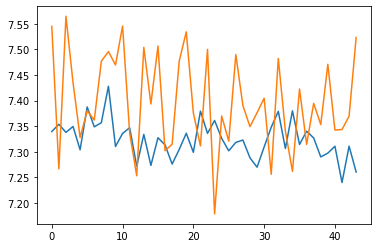

In [179]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val loss')

In [180]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

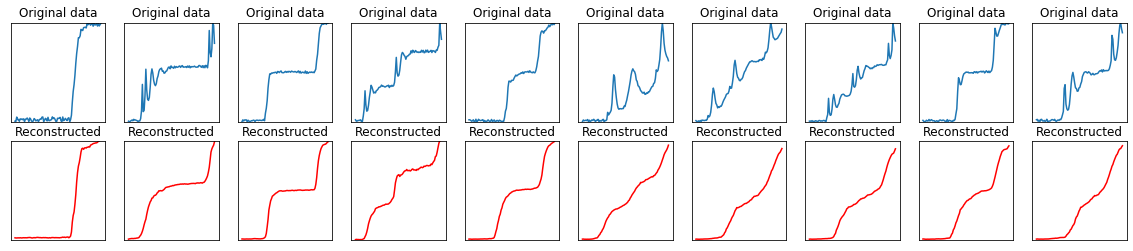

In [181]:
n=10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.plot(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.ylim(0,1)
    plt.title('Original data')
    ax = plt.subplot(2,n,i+1+n)
    plt.plot(decoded_imgs[i],'r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.ylim(0,1)
    plt.title('Reconstructed')
plt.show()

### Mapping latent vector with t-SNE

In [182]:
def TSNE_transform(models,data,batch_size=128,model_name='vae_mnist'):
    
    encoder, decoder = models
    x_test,y_test = data
    latent = encoder.predict(x_test)
    tsne = TSNE(learning_rate=300, n_iter=1500).fit_transform(latent)
    return tsne, y_test

tsne, y_test = TSNE_transform(models,data)    

### Scatter Plot two categories of data

1.0


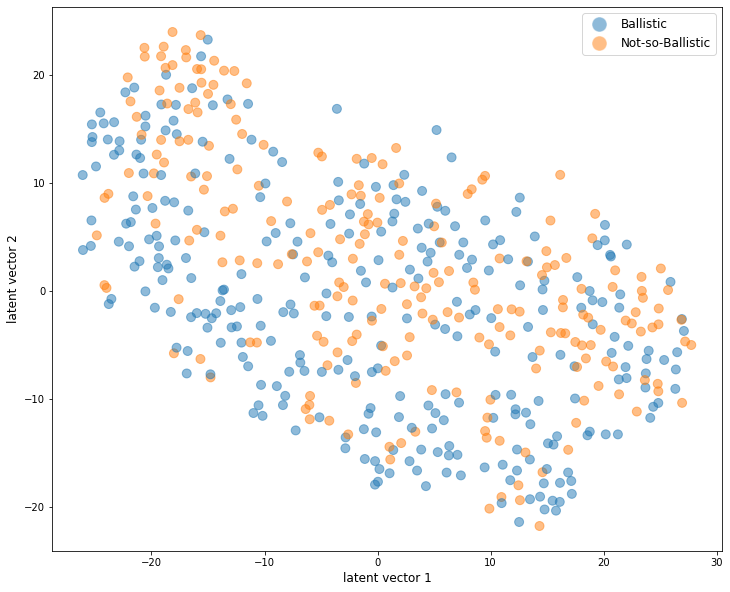

In [183]:
plt.figure(figsize=(12,10))
ax = plt.subplot()
print(y_test[0])
my_dict = {1.0:'Good',0.0:'Bad'}
color_dict = {}
color_dict = {1.0:'tab:blue',0.0:'tab:orange'}
color_list = [color_dict[k] for k in y_test]
label_list = [my_dict[k] for k in y_test]
scatter = ax.scatter(tsne[:,0],tsne[:,1],c=color_list,alpha=0.5,s=80)
    
ax.set_xlabel("latent vector 1",fontsize=12)
ax.set_ylabel("latent vector 2",fontsize=12)
from matplotlib.lines import Line2D
legend_element = [Line2D([0], [0], marker='o', color='w', label='Ballistic',
                          markerfacecolor='tab:blue', markersize=15, alpha=0.5),
                 Line2D([0], [0], marker='o', color='w', label='Not-so-Ballistic',
                          markerfacecolor='tab:orange', markersize=15, alpha=0.5)]
ax.legend(handles=legend_element, loc='upper right', fontsize=12)
plt.show()